In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


%matplotlib inline


In [305]:
class NeuralNetwork():
    def __init__(self,X,Y,nn_layers,n_iters=2000,alpha = 0.01,lambda_=10):
        self.X = X
        self.Y = Y
        self.nn_layers= nn_layers
        self.n_iters= n_iters
        self.alpha= alpha
        self.lambda_= lambda_
        self.params = self.random_weights_initialization(nn_layers)
        self.fp_cache = None
        self.cost = None
        
    def tanh(self,z):
        return np.tanh(z)
    def sigmoid(self,z):
        return 1 / (1+np.exp(-z))
    def sigmoid_deriv(self,z):# z --> sigmoid(Z)
        return z * (1-z)
    def tanh_deriv(self,z): # z --> tanh(Z)
        return 1 - (z)**2
    def relu(self,Z):
        z_copy = np.array(Z,copy=True)
        return np.maximum(0,z_copy)
    def relu_backward(self,dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    def softmax(self,u):
        return np.exp(u) / np.sum(np.exp(u), axis=0, keepdims=True)
    def random_weights_initialization(self,n_layers):
        params = {}

        # n_layers --> (len-1) is no of layers and elements of list are no of neurons in (index+1)th layer

        for i in range(1,len(n_layers)):
            params["W"+str(i)] = np.random.randn(n_layers[i-1],n_layers[i])  * np.sqrt(2/n_layers[i-1])
            params["b"+str(i)] = b3 = np.zeros((1,n_layers[i]))

        return params
    
    
    
    def forward_prop(self,input_X,parameters):   
        cache = {
            "A0":input_X
        }
        last_index = int(len(parameters)/2)
        for i in range(1,last_index):
            cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],parameters["W"+str(i)]) + parameters["b"+str(i)]
            cache["A"+str(i)] = self.relu(cache["Z"+str(i)])

        cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                            parameters["W"+str(last_index)])  + parameters["b"+str(last_index)]
        cache["A"+str(last_index)] = self.sigmoid(cache["Z"+str(last_index)])
        self.fp_cache=cache
        return cache["A"+str(last_index)],cache
    
    
    def compute_cost(self,pred_output,actual_output,parameters,lamdba):    
        A = pred_output
        y =actual_output
        m = y.shape[0]
        norm=0
        for i in range(1,int(len(parameters)/2)):
            norm += np.linalg.norm(parameters["W"+str(i)])

        cost_ =  (1./m)* np.sum((A-y)**2) + (lamdba * norm)/(2*m)
        return np.squeeze(cost_)


    def get_accuracy_value(self,Y_hat, Y):
        testing = Y_hat.copy()
        if Y_hat.shape[1]<=1:
            testing[Y_hat>0.5]= 1 
            testing[Y_hat <= 0.5]=0 
        else:
            testing = np.argmax(Y_hat,axis=1).reshape(Y.shape[0],1)
            Y = np.argmax(Y,axis=1).reshape(Y.shape[0],1)
#         print(testing.T,Y.T)
#         print(testing.shape,Y.shape)
        return (testing == Y).all(axis=1).mean()
    
    def backward_prop(self,Y,cache,parameters):

        last_index = int(len(parameters)/2)
        m = Y.shape[0]
        back_cache = {}

        delta3  = 2*(cache["A"+str(last_index)] - Y) * self.sigmoid_deriv(cache["A"+str(last_index)])
        back_cache["dW"+str(last_index)] = (np.dot(cache["A"+str(last_index-1)].T,delta3)/ m ) + (self.lambda_ / (2 *m)) * parameters["W"+str(last_index)]
        back_cache["db"+str(last_index)] =np.sum(delta3,axis=0,keepdims=True)/ m 

        delta = delta3
        for i in reversed(range(1,last_index)):
            delta =self.relu_backward(np.dot(delta,parameters["W"+str(i+1)].T),cache["Z"+str(i)])
            back_cache["dW"+str(i)] = (np.dot(cache["A"+str(i-1)].T,delta) / m) + (self.lambda_ / (2 *m)) * parameters["W"+str(i)]
            back_cache["db"+str(i)] = np.sum(delta,axis=0,keepdims=True)/ m

        for i in range(1,(last_index)):
            assert (parameters["W"+str(i)].shape == back_cache["dW"+str(i)].shape) 

        return back_cache
    
    def update_params(self,params,backward_cache,learning_rate,lamdba,m):
        ferb = (learning_rate * lamdba)/m
        last_index = int(len(params)/2)
        for i in range(1,last_index+1):
            params["W"+str(i)] = (1-ferb)*params["W"+str(i)]- (learning_rate * backward_cache["dW"+str(i)])
            params["b"+str(i)] = params["b"+str(i)]- (learning_rate * backward_cache["db"+str(i)])
        return params
    
    def train(self,print_cost=False):    
        params  = self.random_weights_initialization(self.nn_layers)
        J_cost =[]
        print("Starting Training")
        for i in range(self.n_iters):

            A3,cache = self.forward_prop(self.X,params)
            J = self.compute_cost(A3,self.Y,params,self.lambda_)
            J_cost.append(J)
            if print_cost:
                if (i%100 == 0):
                    print("iter:",str(i),"cost:",str(J),"Accuracy:",str(self.get_accuracy_value(A3,self.Y)))
                    print("----------------------------------------------------------------------")

            back_cache = self.backward_prop(self.Y,cache,params)

            self.params  = self.update_params(params,back_cache,self.alpha,self.lambda_,self.X.shape[0])
        self.cost  = J_cost
        print("Training Done.")
        print("With \n" + "Cost: "+str(J)+" Accuracy: "+str(self.get_accuracy_value(A3,self.Y)))
        

    
    def predict(self,testX,threshold=0.5):    
        a,_ = self.forward_prop(testX,self.params)
        output = np.array(a,copy=True)
        if a.shape[1]<=1:
            output[output > threshold] = 1
            output[output <= threshold] = 0   
        else:
            output = np.argmax(a,axis=1).reshape(testX.shape[0],1)

        return output
    
    def evaluate(self,input_X,output_y,threshold=0.5):
        predictions = self.predict(input_X,threshold)
        print( " precision:" , str(precision_score(output_y,predictions,average='micro'))[:5],"\n",
        "recall:",str(recall_score(output_y,predictions,average='micro'))[:5],"\n",
        "fl score:",str(f1_score(output_y,predictions,average='micro'))[:5],"\n",
        "accuracy:",str((predictions == output_y).all(axis=1).mean())[:5])
        results = confusion_matrix(output_y,predictions)
        fig, ax = plt.subplots(figsize=(4,4))
        ax.matshow(results,cmap="spring")
        for (i, j), z in np.ndenumerate(results):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                   )
        plt.show()
    
    def plot_cost(self):
        plt.plot(np.arange(len(self.cost)),self.cost)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Cost")
        plt.show()

In [306]:
import sys, numpy as np 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Getting the Data for 1 and 0 to classify:

In [307]:
y_1_train = np.where(y_train == 1)
y_0_train = np.where(y_train == 0)
index_train =np.append(y_1_train[0],y_0_train[0])
np.random.shuffle(index_train)

y_1_test = np.where(y_test == 1)
y_0_test = np.where(y_test == 0)
index_test =np.append(y_1_test[0],y_0_test[0])
np.random.shuffle(index_test)


# index
x_train= x_train[(index_train)]
y_train= y_train[(index_train)]
x_test= x_test[(index_test)]
y_test= y_test[(index_test)]

print(index_train)


[38540 40335 55045 ... 11969 28291 27153]


1

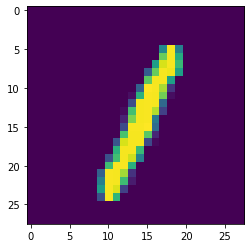

In [308]:
n_samples_train = 12000
i = np.random.randint(0, n_samples_train)
img = Image.fromarray(x_train[i])
plt.imshow(img)

y_train[i]

In [309]:
images, labels = (x_train[0:n_samples_train].reshape(n_samples_train,28*28) /255, y_train[0:n_samples_train].reshape(n_samples_train,1)) 
df = pd.DataFrame(images)
images.shape,labels.shape

((12000, 784), (12000, 1))

In [310]:
# params_ , cost_ = train(images,labels,[images.shape[1],6,4,labels.shape[1]],n_iters=2000,alpha =  0.01,lambda_=10,)
nn_arch=[images.shape[1],6,5,labels.shape[1]]
nn =NeuralNetwork(images,labels,nn_arch,alpha=0.03,lambda_=100)
nn.train(True)

Starting Training
iter: 0 cost: 0.26290295790801516 Accuracy: 0.47633333333333333
----------------------------------------------------------------------
iter: 100 cost: 0.06890609489324258 Accuracy: 0.9941666666666666
----------------------------------------------------------------------
iter: 200 cost: 0.037886115452873834 Accuracy: 0.9961666666666666
----------------------------------------------------------------------
iter: 300 cost: 0.032696656324464675 Accuracy: 0.9971666666666666
----------------------------------------------------------------------
iter: 400 cost: 0.030433227773962013 Accuracy: 0.9974166666666666
----------------------------------------------------------------------
iter: 500 cost: 0.028988638111335046 Accuracy: 0.9975
----------------------------------------------------------------------
iter: 600 cost: 0.027899474142287328 Accuracy: 0.9975833333333334
----------------------------------------------------------------------
iter: 700 cost: 0.02700071804442631 Ac

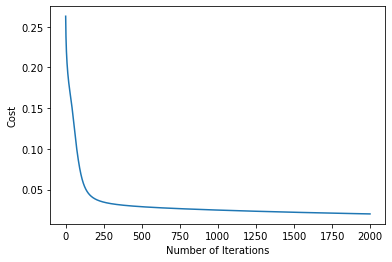

In [311]:
nn.plot_cost()

Testing the Trained Neural Network

In [312]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score ,f1_score


In [313]:
n_test_samples = x_test.shape[0]
testX = x_test.reshape(n_test_samples,28*28)/255
testY = y_test.reshape(n_test_samples,1)


Threshold: 0.5
-------------test set-------------
 precision: 0.999 
 recall: 0.999 
 fl score: 0.999 
 accuracy: 0.999


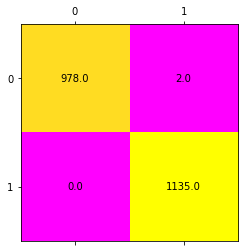

-------------train set-------------
 precision: 0.998 
 recall: 0.998 
 fl score: 0.998 
 accuracy: 0.998


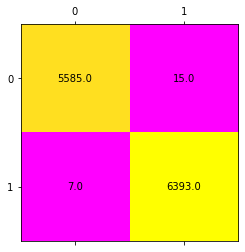

In [314]:
thres = 0.5
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)


Threshold: 0.8
-------------test set-------------
 precision: 0.996 
 recall: 0.996 
 fl score: 0.996 
 accuracy: 0.996


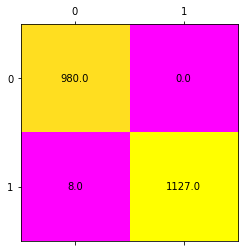

-------------train set-------------
 precision: 0.993 
 recall: 0.993 
 fl score: 0.993 
 accuracy: 0.993


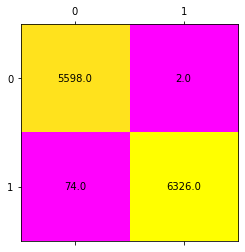

In [315]:
thres = 0.8
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.3
-------------test set-------------
 precision: 0.997 
 recall: 0.997 
 fl score: 0.997 
 accuracy: 0.997


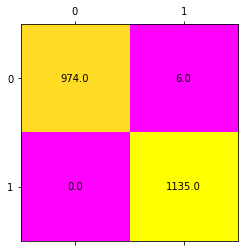

-------------train set-------------
 precision: 0.996 
 recall: 0.996 
 fl score: 0.996 
 accuracy: 0.996


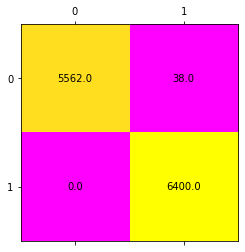

In [316]:
thres = 0.3
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

In [317]:
(x_train_10, y_train_10), (x_test_10, y_test_10) = mnist.load_data()
x_cross_10 = x_train_10[0:5000]
y_cross_10 = y_train_10[0:5000]
x_train_10 = x_train_10[5000:]
y_train_10 = y_train_10[5000:]

n_train_samples = x_train_10.shape[0]
n_train_labels = y_train_10.shape[0]
n_test_samples = x_test_10.shape[0]
n_test_labels = y_test_10.shape[0]
n_cross_samples = x_cross_10.shape[0]
n_cross_labels = y_cross_10.shape[0]

In [318]:
x_input = x_train_10.reshape(n_train_samples,28*28)/255
y_output = y_train_10.reshape(n_train_labels,1)

y_train_labels = np.zeros((n_train_labels,10))
for i_row,j in enumerate(y_output):
    y_train_labels[i_row][j]=1
        
x_input.shape,y_output.shape

((55000, 784), (55000, 1))

In [319]:
nn10 = NeuralNetwork(x_input,y_train_labels,[x_input.shape[1],12,10,10],n_iters=3001,alpha=0.03,lambda_=100)
nn10.params 

{'W1': array([[-0.03651   ,  0.04716525,  0.16026142, ...,  0.09548926,
         -0.11819076,  0.04198525],
        [ 0.00196618, -0.03309098, -0.04765747, ..., -0.01926722,
         -0.02001496,  0.00243729],
        [ 0.06931089,  0.01104688,  0.00585236, ..., -0.01826756,
          0.06294185, -0.02872439],
        ...,
        [-0.03530313,  0.03191708, -0.03054138, ..., -0.04116524,
          0.03855416, -0.09995462],
        [-0.03023696, -0.03322542, -0.0462247 , ..., -0.03426279,
         -0.08456082, -0.00426821],
        [ 0.03745021,  0.01431635, -0.00868479, ..., -0.01888931,
         -0.04681154,  0.01319656]]),
 'b1': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'W2': array([[ 0.32783339, -0.27222758,  0.39406548, -0.14032439, -0.91815306,
         -0.52304638,  0.18696136, -0.09727369, -0.31780689,  0.12289605],
        [ 0.40589986, -0.37268977, -0.277077  ,  0.63179445, -0.41579436,
          0.30168801, -0.33436708, -0.07451717,  0.06243692, -0.20815846

In [320]:
nn10.train(True)

Starting Training
iter: 0 cost: 2.508792766838012 Accuracy: 0.11247272727272727
----------------------------------------------------------------------
iter: 100 cost: 0.9168518882833484 Accuracy: 0.2116909090909091
----------------------------------------------------------------------
iter: 200 cost: 0.8742706001369276 Accuracy: 0.2094
----------------------------------------------------------------------
iter: 300 cost: 0.845947295723672 Accuracy: 0.20978181818181818
----------------------------------------------------------------------
iter: 400 cost: 0.8223145744310111 Accuracy: 0.23065454545454545
----------------------------------------------------------------------
iter: 500 cost: 0.7928837226633996 Accuracy: 0.27949090909090907
----------------------------------------------------------------------
iter: 600 cost: 0.7754565870829977 Accuracy: 0.3281272727272727
----------------------------------------------------------------------
iter: 700 cost: 0.7612803933879316 Accuracy: 0.35

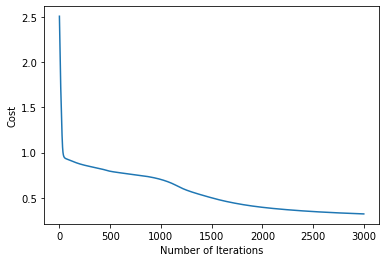

(55000, 10)

In [321]:
nn10.plot_cost()
y_train_labels.shape

In [322]:
x = nn10.predict(x_cross_10.reshape(n_cross_samples,28*28)/255,0.5)

In [323]:
(x.reshape(n_cross_samples,1) == y_cross_10.reshape(n_cross_samples,1)).all(axis=1).mean()

0.8092

 precision: 0.809 
 recall: 0.809 
 fl score: 0.809 
 accuracy: 0.809


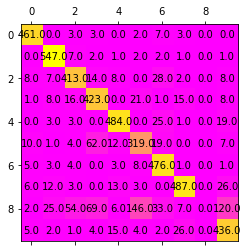

In [324]:
nn10.evaluate(x_cross_10.reshape(n_cross_samples,28*28)/255,y_cross_10.reshape(n_cross_samples,1))